<center><h1>DSCI-552 HOMEWORK 7</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

#### import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, accuracy_score
from skmultilearn.problem_transform import LabelPowerset
from collections import Counter
from imblearn.over_sampling import SMOTE

# 1. Multi-class and Multi-Label Classification Using Support Vector Machines

### 1-(a). Download the Anuran Calls (MFCCs) Data Set from: https://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29. Choose 70% of the data randomly as the training set.

In [2]:
# load dataset
df_mfcc = pd.read_csv('../data/Frogs_MFCCs.csv')
df_mfcc = df_mfcc.drop('RecordID', axis = 1)
df_mfcc.head()

# split dataset to 70% train 30% test
label_cols = ['Family', 'Genus', 'Species']
df_mfcc_X = df_mfcc.loc[:, [col for col in df_mfcc.columns if col not in label_cols]]
df_mfcc_y = df_mfcc.loc[:, label_cols]
df_mfcc_train_X, df_mfcc_test_X, df_mfcc_train_y, df_mfcc_test_y = train_test_split(df_mfcc_X, df_mfcc_y, \
                            test_size = 0.3, random_state = 0)


### 1-(b). Each instance has three labels: Families, Genus, and Species. Each of the labels has multiple classes. We wish to solve a multi-class and multi-label problem. One of the most important approaches to multi-label classification is to train a classifier for each label (binary relevance). We first try this approach:

#### 1-(b)-i. Research exact match and hamming score/ loss methods for evaluating multi- label classification and use them in evaluating the classifiers in this problem.

In [3]:
def predict_y_multilabel(cls_ml, df_test_X):
    df_pred_y = None
    for cls_this_label in cls_ml:
        temp_pred_y = cls_this_label.predict(df_test_X)
        if df_pred_y is None:
            df_pred_y = pd.DataFrame(temp_pred_y)
        else:
            df_pred_y = pd.concat([df_pred_y, pd.DataFrame(temp_pred_y)], axis = 1)
    return df_pred_y

def exact_match_multilabel(cls_ml, df_test_X, df_test_y):
    num_match = 0
    cnt = 0
    
    y_pred = predict_y_multilabel(cls_ml, df_test_X)
    for i, row in y_pred.iterrows():
        if (row.values == df_test_y.iloc[i, :].values).all():
            num_match += 1
        cnt += 1
            
    return num_match / cnt

def hamming_loss_multilabel(cls_ml, df_test_X, df_test_y):
    y_pred = predict_y_multilabel(cls_ml, df_test_X)
    return (y_pred.values != df_test_y.values).sum() / (y_pred.shape[0] * y_pred.shape[1])

#### 1-(b)-ii. Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers. Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.1 You are welcome to try to solve the problem with both standardized 2 and raw attributes and report the results.

In [5]:
# Train SVM using Gaussian Kernel (RBF Kernel)
cls_svm_list = []
for label in label_cols:
    params = {
        'C': [1e-4, 1e-2, 1, 1e2, 1e4],
        'gamma': [1e-4, 1e-2, 1, 1e2, 1e4]
    }
    cls_svm = SVC(kernel = 'rbf', decision_function_shape = 'ovr',)
    cls_svm_cv = GridSearchCV(cls_svm, params, cv = 10, scoring = 'accuracy')
    
    y_this_label = df_mfcc_train_y.loc[:, label]
    cls_svm_cv.fit(df_mfcc_train_X, y_this_label)
    print(cls_svm_cv.best_score_)
    
    # append the model for this label to the list
    cls_svm_list.append(cls_svm_cv.best_estimator_)

0.991460364795355
0.9906659250844143
0.9894746599766482


In [6]:
# exact match and hamming loss score
print('------ SVM with Gaussian Kernel ------')
print('Exact Match score:', '{0:.4%}'.format(exact_match_multilabel(cls_svm_list, df_mfcc_test_X, df_mfcc_test_y)))
print('Hamming Loss:', '{0:.4%}'.format(hamming_loss_multilabel(cls_svm_list, df_mfcc_test_X, df_mfcc_test_y)))


------ SVM with Gaussian Kernel ------
Exact Match score: 98.7031%
Hamming Loss: 0.8646%


In [7]:
# standardize features
scaler = StandardScaler()
df_mfcc_train_X_std = scaler.fit_transform(df_mfcc_train_X)
df_mfcc_test_X_std = scaler.transform(df_mfcc_test_X)

In [8]:
# Train SVM using Gaussian Kernel (RBF Kernel) - using standardized features
cls_svm_std_list = []
for label in label_cols:
    params = {
        'C': [1e-4, 1e-2, 1, 1e2, 1e4],
        'gamma': [1e-4, 1e-2, 1, 1e2, 1e4]
    }
    cls_svm_std = SVC(kernel = 'rbf', decision_function_shape = 'ovr',)
    cls_svm_std_cv = GridSearchCV(cls_svm_std, params, cv = 10, scoring = 'accuracy')
    
    y_this_label = df_mfcc_train_y.loc[:, label]
    cls_svm_std_cv.fit(df_mfcc_train_X_std, y_this_label)
    print(cls_svm_std_cv.best_score_)
    
    # append the model for this label to the list
    cls_svm_std_list.append(cls_svm_std_cv.best_estimator_)

0.9886802202657075
0.9870933131370506
0.9874897440752312


In [9]:
# exact match and hamming loss score
print('------ SVM with Gaussian Kernel (Standardized Features) ------')
print('Exact Match score:', '{0:.4%}'.format(exact_match_multilabel(cls_svm_std_list, df_mfcc_test_X_std, df_mfcc_test_y)))
print('Hamming Loss:', '{0:.4%}'.format(hamming_loss_multilabel(cls_svm_std_list, df_mfcc_test_X_std, df_mfcc_test_y)))


------ SVM with Gaussian Kernel (Standardized Features) ------
Exact Match score: 98.0547%
Hamming Loss: 1.1116%


> Training SVM with Gaussian Kernel for both non-standardized and standardized features give similarly good results where exact match score is high and hamming loss is low

#### 1-(b)-iii. Repeat 1(b)ii with L1-penalized SVMs.3 Remember to standardize4 the at- tributes. Determine the weight of the SVM penalty using 10 fold cross vali- dation.

In [10]:
# training LinearSVC with L1 penalty
cls_svm_l1_list = []

for label in label_cols:
    params = {'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]}
    cls_svm_l1 = LinearSVC(penalty = 'l1', multi_class = 'ovr', random_state = 0, dual = False, max_iter = 50000)
    cls_svm_l1_cv = GridSearchCV(cls_svm_l1, params, cv = 10, scoring = 'accuracy')
    
    y_this_label = df_mfcc_train_y.loc[:, label]
    cls_svm_l1_cv.fit(df_mfcc_train_X_std, y_this_label)
    print(cls_svm_l1_cv.best_score_)
    
    # append the model for this label to the list
    cls_svm_l1_list.append(cls_svm_l1_cv.best_estimator_)

0.9376510776610181
0.9529367446116949
0.9586954463694027


In [11]:
# exact match and hamming loss score
print('------ SVM with L1 penalty (Standardized Features) ------')
print('Exact Match score:', '{0:.4%}'.format(exact_match_multilabel(cls_svm_l1_list, df_mfcc_test_X_std, df_mfcc_test_y)))
print('Hamming Loss:', '{0:.4%}'.format(hamming_loss_multilabel(cls_svm_l1_list, df_mfcc_test_X_std, df_mfcc_test_y)))


------ SVM with L1 penalty (Standardized Features) ------
Exact Match score: 91.3386%
Hamming Loss: 5.3883%


> using SVM with L1 penalty (LinearSVC in sklearn) provides a slightly worse result compared to SVM with Gaussian Kernel

#### 1-(b)-iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance. Report your conclusions about the classifiers you trained.

In [12]:
# check number of samples for each family&genus&species combination
df_mfcc_train_y.value_counts()

Family           Genus          Species               
Leptodactylidae  Adenomera      AdenomeraHylaedactylus    2449
Hylidae          Hypsiboas      HypsiboasCordobae          786
Leptodactylidae  Adenomera      AdenomeraAndre             461
Dendrobatidae    Ameerega       Ameeregatrivittata         387
Hylidae          Hypsiboas      HypsiboasCinerascens       321
                 Dendropsophus  HylaMinuta                 214
Leptodactylidae  Leptodactylus  LeptodactylusFuscus        183
Hylidae          Scinax         ScinaxRuber                101
                 Osteocephalus  OsteocephalusOophagus       86
Bufonidae        Rhinella       Rhinellagranulosa           48
dtype: int64

In [13]:
# check distribution of each of the 3 labels
for col in df_mfcc_train_y.columns:
    print(Counter(df_mfcc_train_y[col]), '\n')

Counter({'Leptodactylidae': 3093, 'Hylidae': 1508, 'Dendrobatidae': 387, 'Bufonidae': 48}) 

Counter({'Adenomera': 2910, 'Hypsiboas': 1107, 'Ameerega': 387, 'Dendropsophus': 214, 'Leptodactylus': 183, 'Scinax': 101, 'Osteocephalus': 86, 'Rhinella': 48}) 

Counter({'AdenomeraHylaedactylus': 2449, 'HypsiboasCordobae': 786, 'AdenomeraAndre': 461, 'Ameeregatrivittata': 387, 'HypsiboasCinerascens': 321, 'HylaMinuta': 214, 'LeptodactylusFuscus': 183, 'ScinaxRuber': 101, 'OsteocephalusOophagus': 86, 'Rhinellagranulosa': 48}) 



In [14]:
# specify numbers of values of each label to oversample 
cnt_after_family = {'Dendrobatidae': 1000, 'Bufonidae': 1000}
cnt_after_genus = {'Ameerega': 1000, 'Dendropsophus': 1000, 'Leptodactylus': 1000, 'Scinax': 1000, \
                   'Osteocephalus': 1000, 'Rhinella': 1000}
cnt_after_species = {'AdenomeraAndre': 500, 'Ameeregatrivittata': 500, 'HypsiboasCinerascens': 500, \
                     'HylaMinuta': 500, 'LeptodactylusFuscus': 500, 'ScinaxRuber': 500, \
                     'OsteocephalusOophagus': 500, 'Rhinellagranulosa': 500}
cnt_after = [cnt_after_family, cnt_after_genus, cnt_after_species]

In [15]:
# train LinearSVC with L1 penalty - SMOTE

cls_svm_l1_smote_list = []

for i, label in enumerate(label_cols):
    # oversample using SMOTE
    y_this_label = df_mfcc_train_y.loc[:, label]
    sm = SMOTE(sampling_strategy = cnt_after[i])
    df_mfcc_train_X_std_smote, y_this_label_smote = sm.fit_resample(df_mfcc_train_X_std, y_this_label)
    
    params = {'C': [1e-6, 1e-4, 1e-2, 1, 1e2, 1e4, 1e6]}
    cls_svm_l1_smote = LinearSVC(penalty = 'l1', multi_class = 'ovr', random_state = 0, dual = False, max_iter = 50000)
    cls_svm_l1_smote_cv = GridSearchCV(cls_svm_l1_smote, params, cv = 10, scoring = 'accuracy')
    
    cls_svm_l1_smote_cv.fit(df_mfcc_train_X_std_smote, y_this_label_smote)
    print(cls_svm_l1_smote_cv.best_score_)
    
    # append the model for this label to the list
    cls_svm_l1_smote_list.append(cls_svm_l1_smote_cv.best_estimator_)
    

0.9398590290193921
0.9492884361147833
0.9567433117076638


In [16]:
# exact match and hamming loss score
print('------ SVM with L1 penalty (SMOTE Oversampling) ------')
print('Exact Match score:', '{0:.4%}'.format(exact_match_multilabel(cls_svm_l1_smote_list, df_mfcc_test_X_std, df_mfcc_test_y)))
print('Hamming Loss:', '{0:.4%}'.format(hamming_loss_multilabel(cls_svm_l1_smote_list, df_mfcc_test_X_std, df_mfcc_test_y)))


------ SVM with L1 penalty (SMOTE Oversampling) ------
Exact Match score: 88.6985%
Hamming Loss: 6.4227%


> After using SMOTE to oversample minority classes, it turned out that the performance is slightly worse as the exact match score reduced from 91% to 88% and hamming loss increased from 5% to 6%

#### 1-(b)-v. Extra Practice: Study the Classifier Chain method and apply it to the above problem.

In [45]:
# # use classifier chain on SVM with L1 Penalty
# cls_svm_chain_list = []

# for label in range(df_mfcc_train_y.shape[1]):
#     params = {'C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]}
#     cls_svm_chain = LinearSVC(penalty = 'l1', multi_class = 'ovr', random_state = 0, dual = False, max_iter = 50000)
#     cls_svm_chain_cv = GridSearchCV(cls_svm_chain, params, cv = 10, scoring = 'accuracy')
    
#     temp_merge = pd.concat([pd.DataFrame(df_mfcc_train_X_std), df_mfcc_train_y.reset_index(drop = True)], axis = 1)
#     ind_x = df_mfcc_train_X_std.shape[1] + label
#     x_this_label = temp_merge.iloc[:, :ind_x]
#     # get dummy variable as Y that will be used to train is categorical
#     x_this_label = pd.get_dummies(x_this_label, drop_first = True)
#     y_this_label = df_mfcc_train_y.iloc[:, label]
#     cls_svm_chain_cv.fit(x_this_label, y_this_label)
#     print(cls_svm_chain_cv.best_score_)
    
#     # append the model for this label to the list
#     cls_svm_chain_list.append(cls_svm_chain_cv.best_estimator_)
    

In [ ]:
# # functions for Classifier Chain
# def predict_y_multilabel_chain(cls_ml, df_test_X, df_test_y):
#     df_pred_y = None
#     for i, cls_this_label in enumerate(cls_ml):
#         temp_test_X = pd.concat([df_test_X, df_test_y], axis = 1)
#         ind_x = df_test_X.shape[1] + i
#         test_X_this_label = temp_test_X.iloc[:, :ind_x]
#         temp_pred_y = cls_this_label.predict(test_X_this_label)
#         if df_pred_y is None:
#             df_pred_y = pd.DataFrame(temp_pred_y)
#         else:
#             df_pred_y = pd.concat([df_pred_y, pd.DataFrame(temp_pred_y)], axis = 1)
#     return df_pred_y

# def exact_match_multilabel_chain(cls_ml, df_test_X, df_test_y):
#     num_match = 0
#     cnt = 0
    
#     y_pred = predict_y_multilabel_chain(cls_ml, df_test_X, df_test_y)
#     for i, row in y_pred.iterrows():
#         if (row.values == df_test_y.iloc[i, :].values).all():
#             num_match += 1
#         cnt += 1
            
#     return num_match / cnt

# def hamming_loss_multilabel_chain(cls_ml, df_test_X, df_test_y):
#     y_pred = predict_y_multilabel_chain(cls_ml, df_test_X, df_test_y)
#     return (y_pred.values != df_test_y.values).sum() / (y_pred.shape[0] * y_pred.shape[1])

In [ ]:
# # exact match and hamming loss score
# print('------ SVM with L1 penalty (Classifier Chain) ------')
# print('Exact Match score:', '{0:.4%}'.format(exact_match_multilabel_chain(cls_svm_chain_list, df_mfcc_test_X_std, df_mfcc_test_y)))
# print('Hamming Loss:', '{0:.4%}'.format(hamming_loss_multilabel_chain(cls_svm_chain_list, df_mfcc_test_X_std, df_mfcc_test_y)))


#### 1-(b)-vi. Extra Practice: Research how confusion matrices, precision, recall, ROC, and AUC are defined for multi-label classification and compute them for the classifiers you trained in above.

# 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set
### Monte-Carlo Simulation: Perform the following procedures 50 times, and report the average and standard deviation of the 50 Hamming Distances that you calculate.

In [25]:
# define functions
def hamming_distance(y_true, y_pred):
    hmm_dist_list = []
    for i in range(len(y_pred)):
        hmm_dist = 0
        for j in range(3):
            if y_pred.iloc[i, j] != y_true.iloc[i, j]:
                hmm_dist += 1
        hmm_dist_list.append(hmm_dist)
    return np.mean(hmm_dist_list)

def hamming_score(y_true, y_pred):
    hmm_score_list = []
    for i in range(len(y_pred)):
        set_y_true = set(y_true.loc[i, :])
        set_y_pred = set(y_pred.loc[i, :])
        hmm_score = len(set_y_true.intersection(set_y_pred)) / len(set_y_true.union(set_y_pred))
        hmm_score_list.append(hmm_score)
    return np.mean(hmm_score_list)

def hamming_loss(y_true, y_pred):
    return (y_pred.values != y_true.values).sum() / (y_pred.shape[0] * y_pred.shape[1])

> - hamming distance calculation is referred from https://ailab.ijs.si/dunja/SiKDD2011/Papers/Gjorgjioski_Multilabel.pdf where it is explained to be the number of positions two strings mismatch (in string dissimilarity context). The same concept is applied to multilabel classification where hamming distance is the number of labels that the prediction mismatches true value.
> - hamming score calculation is referred from the comment of Franck Dernoncourt from https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit where it is explained as: the ratio of (the intersection of prediction and true labels) and (the union of prediction and true labels), average across all instances. The formula is adapted to fit the multiclass & multilabel problem in this context.
> - hamming loss calculation is adapted from sklearn package https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html since the package doesn't support multilabel multiclass problem but the metric is defined as the proportion of the misclassified labels (take into account the partially correct cases)

In [27]:
# perform 50 iterations of K-Means clustering
df_result_kmeans = pd.DataFrame(columns = ['iteration', 'optimal_num_cluster', 'optimal_ch_score', \
                                           'hamming_dist', 'hamming_loss'])

scaler = StandardScaler()
df_mfcc_X_std = scaler.fit_transform(df_mfcc_X)

for i in range(1, 51):
    if i % 5 == 0:
        print('Iteration #', i)
    
    # perform k-means clustering 49 times - k from 2 to 50
    list_num_clusters = np.arange(2, 51, 1)
    
    best_km = None
    best_ch_score = 0
    best_num_cluster = 0
    
    for num_cluster in list_num_clusters:
        # make random_state different for the 50 iterations 
        km = KMeans(n_clusters = num_cluster, init = 'random', random_state = i)
        km.fit(df_mfcc_X_std)
        ch_score = calinski_harabasz_score(df_mfcc_X_std, km.labels_)
        
        if ch_score > best_ch_score:
            best_km = km
            best_num_cluster = num_cluster
            best_ch_score = ch_score
        
    # assign clusters to data from best KMeans
    df_mfcc_kmean = df_mfcc.copy()
    df_mfcc_kmean['cluster_no'] = best_km.labels_

    # each cluster's majority true labels - family, genus, species
    df_mfcc_kmean_majority_label = df_mfcc_kmean.groupby('cluster_no')[label_cols].agg(pd.Series.mode)
    
    y_true = df_mfcc_kmean[label_cols]
    y_pred = df_mfcc_kmean.merge(df_mfcc_kmean_majority_label, on = 'cluster_no', suffixes = ['_true', ''])
    y_pred = y_pred[label_cols]
    
    hmm_dist = hamming_distance(y_true, y_pred)
    hmm_loss = hamming_loss(y_true, y_pred)
    
    df_result_kmeans.loc[len(df_result_kmeans), :] = [i, best_num_cluster, best_ch_score, hmm_dist, hmm_loss]

Iteration # 5
Iteration # 10
Iteration # 15
Iteration # 20
Iteration # 25
Iteration # 30
Iteration # 35
Iteration # 40
Iteration # 45
Iteration # 50


In [28]:
df_result_kmeans

,iteration,optimal_num_cluster,optimal_ch_score,hamming_dist,hamming_loss
0,1,2,3284.605925,2.518833,0.839611
1,2,2,3284.605925,2.518833,0.839611
2,3,2,3284.605925,2.518833,0.839611
3,4,2,3284.605925,2.518833,0.839611
4,5,2,3284.605925,2.518833,0.839611
5,6,2,3284.605925,2.518833,0.839611
6,7,2,3284.605925,2.518833,0.839611
7,8,2,3284.605925,2.518833,0.839611
8,9,2,3284.605925,2.518833,0.839611
9,10,2,3284.605925,2.518833,0.839611


In [29]:
# average and SD of hamming distances from 50 iterations
print('Hamming Distance average:', df_result_kmeans['hamming_dist'].mean())
print('Hamming Distance standard deviation:', df_result_kmeans['hamming_dist'].std())


Hamming Distance average: 2.5188325225851287
Hamming Distance standard deviation: 0.0


> For the 50 iterations of K-means, it is noticed that the optimal number of clusters are the same (n_clusters = 2) as well as the hamming distance (sd = 0). It could be inferred that the clusters we got is global optima.

#### 2-(a). Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split the data into train and test, as we are not performing supervised learning in this exercise). Choose k ∈ {1, 2, . . . , 50} automatically based on one of the methods provided in the slides (CH or Gap Statistics or scree plots or Silhouettes) or any other method you know.

In [30]:
# perform k-means clustering 49 times - k from 2 to 50
df_ch_score = pd.DataFrame(columns = ['num_clusters', 'CH_score'])
list_num_clusters = np.arange(2, 51, 1)

for num_cluster in list_num_clusters:
    km = KMeans(n_clusters = num_cluster, random_state = 0)
    km.fit(df_mfcc_X_std)
    ch_score = calinski_harabasz_score(df_mfcc_X_std, km.labels_)
    df_ch_score.loc[len(df_ch_score), :] = [num_cluster, ch_score]

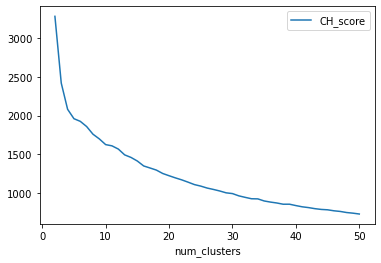

In [31]:
# plot ch_score for different n_clusters
df_ch_score.plot(x = 'num_clusters', y = 'CH_score')
plt.show()

In [32]:
# max CH_score
df_ch_score[df_ch_score['CH_score'] == df_ch_score['CH_score'].max()]

,num_clusters,CH_score
0,2,3284.605925


> number of clusters = 2 gives the highest CH score

#### 2-(b). In each cluster, determine which family is the majority by reading the true labels. Repeat for genus and species.

In [33]:
# K-Mean with 2 clusters
km_2cluster = KMeans(n_clusters = 2, random_state = 0)
km_2cluster.fit(df_mfcc_X_std)

# add cluster label to the data
df_mfcc_kmean_2 = df_mfcc.copy()
df_mfcc_kmean_2['cluster_no'] = km_2cluster.labels_

# each cluster's majority true labels - family, genus, species
df_mfcc_kmean_2_majority_label = df_mfcc_kmean_2.groupby('cluster_no')[label_cols].agg(pd.Series.mode)

In [34]:
df_mfcc_kmean_2_majority_label

,Family,Genus,Species
cluster_no,,,
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCordobae


#### 2-(c). Now for each cluster you have a majority label triplet (family, genus, species). Calculate the average Hamming distance, Hamming score, and Hamming loss5 between the true labels and the labels assigned by clusters.

In [35]:
y_true = df_mfcc_kmean_2[label_cols]
y_pred = df_mfcc_kmean_2.merge(df_mfcc_kmean_2_majority_label, on = 'cluster_no', suffixes = ['_true', ''])
y_pred = y_pred[label_cols]

In [36]:
print('Hamming distance:', hamming_distance(y_true, y_pred))

Hamming distance: 2.5188325225851287


In [37]:
print('Hamming score:', hamming_score(y_true, y_pred))

Hamming score: 0.15538568450312717


In [38]:
print('Hamming Loss:', hamming_loss(y_true, y_pred))

Hamming Loss: 0.8396108408617096


> It can be seen that using the majority label as a prediction after doing K-Means clustering provides poor results since the hamming distance and hamming loss are high and hamming score is low.

# 3. ISLR 12.6.2

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [40]:
X = [0.3, 0.4, 0.5, 0.7, 0.8, 0.45]

#### a) Dendrogram for complete linkage

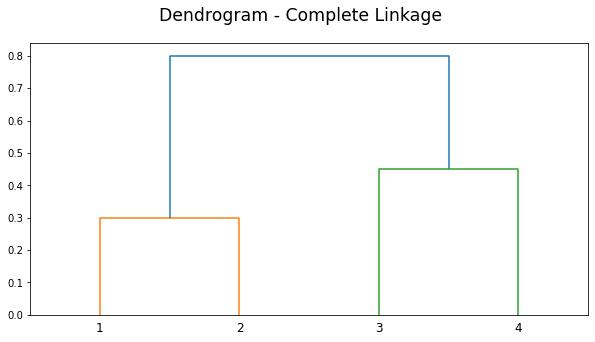

In [41]:
Z = linkage(X, 'complete')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels = [1, 2, 3, 4])
plt.suptitle('Dendrogram - Complete Linkage', fontsize = 'xx-large')
plt.show()

#### b) Dendrogram for single linkage

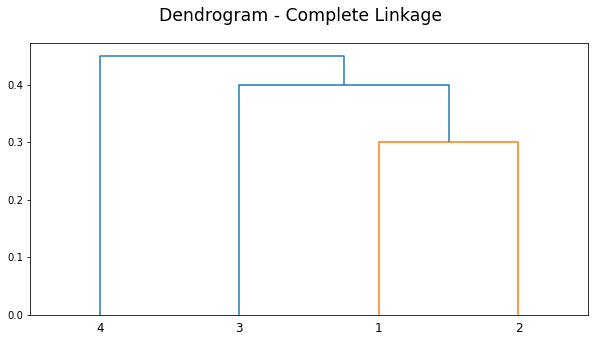

In [42]:
Z = linkage(X, 'single')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels = [1, 2, 3, 4])
plt.suptitle('Dendrogram - Complete Linkage', fontsize = 'xx-large')
plt.show()

#### c) Two clusters of Complete linkage will be a cluster of (point 1 and 2) and (point 3 and 4)

#### d) Two clusters of Single linkage will be a cluster of (1, 2, and 3) and (point 4)

#### e) If the points are repositioned, dendrograms are still the same

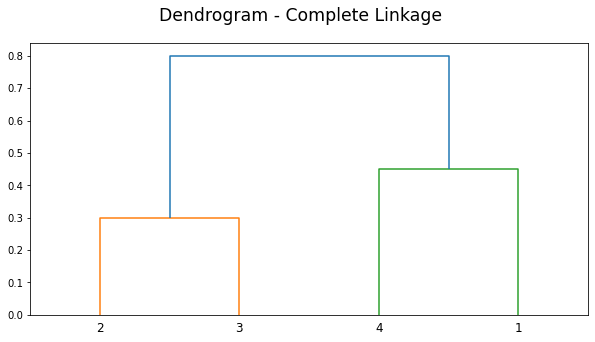

In [43]:
Z = linkage(X, 'complete')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels = [2, 3, 4, 1])
plt.suptitle('Dendrogram - Complete Linkage', fontsize = 'xx-large')
plt.show()

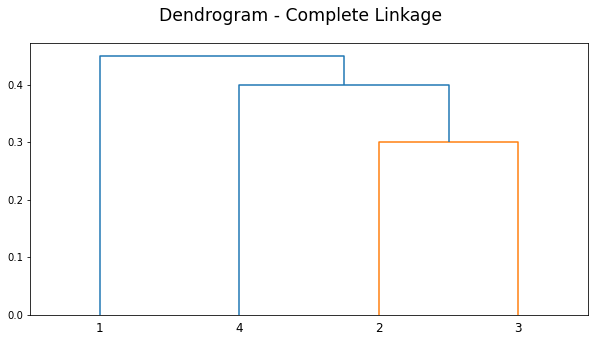

In [44]:
Z = linkage(X, 'single')
fig = plt.figure(figsize=(10, 5))
dn = dendrogram(Z, labels = [2, 3, 4, 1])
plt.suptitle('Dendrogram - Complete Linkage', fontsize = 'xx-large')
plt.show()